In [1]:
%matplotlib inline
#!pip uninstall tensorflow -y
#!pip install --upgrade tensorflow-gpu
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from glob import glob
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount("/content/drive") # Don't change this.
imgarray=np.load('/content/drive/MyDrive/brain tumor segmentation/asad data/data/appended all/training/appended flair/flair.npy')
maskarray=np.load('/content/drive/MyDrive/brain tumor segmentation/asad data/data/appended all/training/appended masks/masks.npy')

Mounted at /content/drive


In [3]:
x_train,x_test,y_train,y_test=train_test_split(imgarray, maskarray, test_size = 0.20, random_state = 101)


In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 101)
x_train.shape

(124, 128, 128, 128)

In [38]:
x_train1=x_train[:,:,:,80:83]
x_test1=x_test[:,:,:,80:83]
y_train1=y_train[:,:,:,80:83]
y_test1=y_test[:,:,:,80:83]
x_val1=x_val[:,:,:,80:83]
y_val1=y_val[:,:,:,80:83]

In [40]:
print("X_train shape=",x_train1.shape), print("y_train1.shape=",y_train1.shape),print("x_val1.shape=",x_val1.shape),print("y_val1.shape=",y_val1.shape)

X_train shape= (124, 128, 128, 3)
y_train1.shape= (124, 128, 128, 3)
x_val1.shape= (32, 128, 128, 3)
y_val1.shape= (32, 128, 128, 3)


(None, None, None, None)

In [41]:
y_train_cat=tf.keras.utils.to_categorical(y_train1, num_classes=4, dtype='float32')
y_val1_cat=tf.keras.utils.to_categorical(y_val1, num_classes=4, dtype='float32')

y_train_cat.shape,

(124, 128, 128, 3, 4)

In [5]:
num_classes = 4
#input_shape = X_train.shape[1:] #(480,480,3)
smooth = 1.
nproc = 8

In [6]:
from keras import backend as K
from keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        print("max pooling with argmax")
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        print("i guess its subsampling")
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]


    def compute_mask(self, inputs, mask=None):
        print("no idea what this is: but computing mask")
        return 2 * [None]


'''class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        # one is pool and one is mask
        updates, mask = inputs[0], inputs[1]

        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')     # it gives a dynamic shape of a given tensor. 

            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')      #creates ones of the same shape as the mask
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(tf.range(output_shape[0], dtype='int32'),shape=batch_shape)
            b = one_like_mask * batch_range

            y = mask // (output_shape[2] * output_shape[3])

            x = (mask // output_shape[3]) % output_shape[2]

            feature_range = tf.range(output_shape[3], dtype='int32')

            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)       # Prints the number of elements in the updates
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )'''
class MaxUnpooling2D(Layer):
      def __init__(self, size=(2, 2), **kwargs):
          super(MaxUnpooling2D, self).__init__(**kwargs)
          self.size = size

      def call(self, inputs, output_shape=None):
          updates, mask = inputs[0], inputs[1]
          with tf.compat.v1.variable_scope(self.name):
              mask = K.cast(mask, 'int32')
              input_shape = tf.shape(updates, out_type='int32')
              #print(updates.shape)
              #print(mask.shape)
              if output_shape is None:
                  output_shape = (
                      input_shape[0],
                      input_shape[1] * self.size[0],
                      input_shape[2] * self.size[1],
                      input_shape[3])

              ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                                    K.flatten(updates),
                                    [K.prod(output_shape)])

              input_shape = updates.shape
              out_shape = [-1,
                          input_shape[1] * self.size[0],
                          input_shape[2] * self.size[1],
                          input_shape[3]]
          return K.reshape(ret, out_shape)

      def get_config(self):
          config = super().get_config().copy()
          config.update({
              'size': self.size
          })
          return config

      def compute_output_shape(self, input_shape):
          mask_shape = input_shape[1]
          return (
                  mask_shape[0],
                  mask_shape[1]*self.size[0],
                  mask_shape[2]*self.size[1],
                  mask_shape[3]
                  )

In [28]:
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization

#from layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size, name="block1_pool")(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size, name="block2_pool")(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size, name="block3_pool")(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block4_conv1")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv2")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv3")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size, name="block4_pool")(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size, name="block5_pool")(conv_13)
   
    # decoder
    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])
    
    conv_14 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    conv_26 = Dense(n_labels)(conv_26)
    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")
    

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model
   

In [35]:

y_train1.shape

(124, 128, 128, 3)

In [22]:
y_train2=tf.keras.utils.to_categorical(
    y_train1, num_classes=4, dtype='float32'
)
y_train2.shape

(124, 128, 128, 3, 4)

In [26]:
y_val2=tf.keras.utils.to_categorical(
    y_val1, num_classes=4, dtype='float32'
)
y_val2.shape

(32, 128, 128, 3, 4)

In [27]:
x_train1.shape,x_test1.shape,y_train2.shape,x_val1.shape,y_val2.shape

((124, 128, 128, 3),
 (39, 128, 128, 3),
 (124, 128, 128, 3, 4),
 (32, 128, 128, 3),
 (32, 128, 128, 3, 4))

In [29]:
model= segnet(input_shape=(128,128,3), n_labels=4)  #, single_model
model.summary()

max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
Build decoder done..
Model: "SegNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 128, 

In [30]:
VGG16_MODEL=tf.keras.applications.VGG16(include_top=False, weights='imagenet')

In [31]:
from tensorflow.keras.layers import Conv2D
layers = model.layers
merged_layers = []
count = 1
for _layer in layers:
  if isinstance(_layer, Convolution2D):
    merged_layers.append(_layer)
  if _layer.name == "block5_pool":
    break

vgg_layer =[]
vgg_layers = VGG16_MODEL.layers
for _layer in vgg_layers:
  if isinstance(_layer, Conv2D):
    vgg_layer.append(_layer)

for seg_model, vgg_model in zip(merged_layers, vgg_layer):
  wk0 = vgg_model.get_weights()
  seg_model.set_weights(wk0)

In [32]:
sgd = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer='sgd', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [37]:
y_val2.shape,x_val1.shape

((32, 128, 128, 3, 4), (32, 128, 128, 3))

In [34]:
hist = model.fit(x_train1, y_train2, epochs= 100, batch_size= 18, validation_data= (x_val1, y_val2), verbose=1)

Epoch 1/100
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask


ValueError: ignored

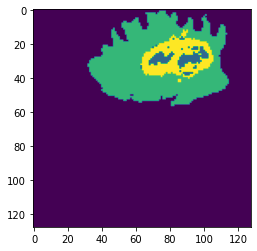

In [15]:
plt.imshow(y_train1[3,:,:,0])

In [16]:
np.unique(y_train1)
x_test.shape


(39, 128, 128, 128)

max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask


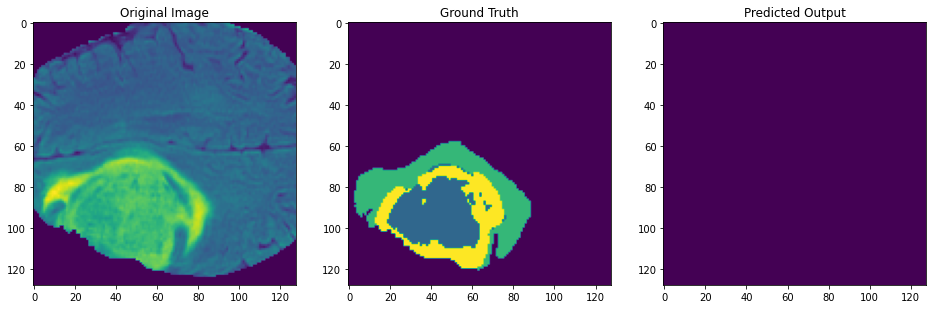

In [17]:
import numpy 
img_num = numpy.random.randint(0,38)
mask_number=numpy.random.randint(0,3)

img_pred = model.predict(x_test1)
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test1[img_num,:,:,mask_number])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test1[img_num,:,:,mask_number])
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow((img_pred[img_num,:,:,mask_number]))
plt.title('Predicted Output')
plt.show()

In [19]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())